In [1]:
import os
#os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'  # to avoid too many logging messages
import pandas as pd, numpy as np, random, shutil
import tensorflow as tf, re, math
import tensorflow.keras.backend as K
import sklearn
import matplotlib.pyplot as plt
import tensorflow_addons as tfa
#import tensorflow_probability as tfp
import wandb
import yaml

from IPython import display as ipd
from glob import glob
from tqdm import tqdm
from sklearn.model_selection import KFold, StratifiedKFold, GroupKFold, StratifiedGroupKFold
from sklearn.metrics import roc_auc_score
from sklearn.utils.class_weight import compute_class_weight

/Users/makoto/homebrew/Caskroom/miniforge/base/envs/rsna2023/lib/python3.10/site-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


### Configs

In [2]:
class CFG:
    wandb         = False

    REPLICAS = 4

    #competition   = 'RSNA2023ATD' 
    #_wandb_kernel = 'm-noda'
    debug         = False
    comment       = 'EfficientNetV2B1'
    #exp_name      = 'baseline-v5: ds-v3 + multi_head' 
    
    # use verbose=0 for silent, vebose=1 for interactive,
    verbose      = 1
    display_plot = True

    # device
    #device = "TPU-VM" #or "GPU"

    model_name = 'EfficientNetV2B1'

    seed = 123

    folds = 5
    
    # which folds to train
    selected_folds = [0, 1, 2]

    # size of the image
    img_size = [256, 256]

    batch_size = 32
    epochs = 5

    loss      = 'BCE & CCE'
    
    optimizer = tf.keras.optimizers.legacy.Adam

    augment   = True

    # scale-shift-rotate-shear
    transform = 0.90  # transform prob
    fill_mode = 'constant'
    rot    = 2.0
    shr    = 2.0
    hzoom  = 50.0
    wzoom  = 50.0
    hshift = 10.0
    wshift = 10.0

    # flip
    hflip = True
    vflip = True

    # clip
    clip = False

    # lr-scheduler
    scheduler   = 'cosine'
   
    # dropout
    drop_prob   = 0.6
    drop_cnt    = 5
    drop_size   = 0.05
    
    # cut-mix-up
    mixup_prob = 0.0
    mixup_alpha = 0.5
    cutmix_prob = 0.0
    cutmix_alpha = 2.5

    # pixel-augment
    p_pixel_aug = 0.90
    sat  = [0.7, 1.3]
    cont = [0.8, 1.2]
    bri  = 0.15
    hue  = 0.05

    # test-time augs
    tta = 1
    
    # target column
    target_col  = [ "bowel_injury", "extravasation_injury", "kidney_healthy", "kidney_low",
                   "kidney_high", "liver_healthy", "liver_low", "liver_high",
                   "spleen_healthy", "spleen_low", "spleen_high"] # not using "bowel_healthy" & "extravasation_healthy"


### Seeding for reproducibility

In [3]:
def seeding(SEED):
    np.random.seed(SEED)
    random.seed(SEED)
    os.environ['PYTHONHASHSEED'] = str(SEED)
    tf.random.set_seed(SEED)
    print('seeding done!!!')
seeding(CFG.seed)

seeding done!!!


### Prepare train data, test data

In [4]:

df = pd.read_csv('./Dataset/train.csv')

test_df = pd.read_csv('./Dataset/test.csv')

### Data split into train and valid

In [5]:
df['stratify'] = ''

for col in CFG.target_col:
    df['stratify'] += df[col].astype(str)

df = df.reset_index(drop=True)

skf = StratifiedGroupKFold(n_splits=CFG.folds, shuffle=True, random_state=CFG.seed)

for  fold , (train_idx, val_idx) in enumerate(skf.split(df, df['stratify'], df['patient_id'])):
    df.loc[val_idx, 'fold'] = fold

df['fold'] = df['fold'].astype(int)


pd.set_option('display.max_rows', 100)
display(df.groupby(['fold', 'patient_id']).size())

/Users/makoto/homebrew/Caskroom/miniforge/base/envs/rsna2023/lib/python3.10/site-packages/sklearn/model_selection/_split.py:950: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


fold  patient_id
0     43             59
      263            12
      4331           27
      4639          106
      7411           95
                   ... 
4     60993          29
      61742         104
      64194          74
      64256          22
      65456          16
Length: 246, dtype: int64

### Data Augmentation

In [6]:
def random_int(shape=[], minval=0, maxval=1):
    return tf.random.uniform(shape=shape, minval=minval, maxval=maxval, dtype=tf.int32)


def random_float(shape=[], minval=0.0, maxval=1.0):
    return tf.random.uniform(shape=shape, minval=minval, maxval=maxval, dtype=tf.float32)


# make affine transformation matrix
# https://cs.kwansei.ac.jp/prog1/affine.html
def get_matrix(shear, height_zoom, width_zoom, height_shift, width_shift):

    # degrees to radians
    shear = math.pi * shear / 180.


    def get_3x3_mat(list):
        return tf.reshape(tf.concat([list], axis=0), [3, 3])
    

    one = tf.constant([1], dtype='float32')
    zero = tf.constant([0], dtype='float32')

    # for shear matrix
    cos = tf.math.cos(shear)
    sin = tf.math.sin(shear)

    shear_matrix = get_3x3_mat([one,  sin,  zero,
                                zero, cos,  zero,
                                zero, zero, one])
    
    zoom_matrix = get_3x3_mat([one/height_zoom, zero,           zero,
                               zero,            one/width_zoom, zero,
                               zero,            zero,           one])
    
    shift_matrix = get_3x3_mat([one,  zero, height_shift, 
                                zero, one,  width_shift, 
                                zero, zero, one])
    
    #　return composite transformation
    return K.dot(shear_matrix, K.dot(zoom_matrix, shift_matrix))
    

# apply affine transformation
def transform(image, DIM=CFG.img_size):

    # add padding to align image sizes
    if DIM[0]>DIM[1]:
        diff  = (DIM[0]-DIM[1])
        pad   = [diff//2, diff//2 + diff%2]
        image = tf.pad(image, [[0, 0], [pad[0], pad[1]],[0, 0]])
        NEW_DIM = DIM[0]

    elif DIM[0]<DIM[1]:
        diff  = (DIM[1]-DIM[0])
        pad   = [diff//2, diff//2 + diff%2]
        image = tf.pad(image, [[pad[0], pad[1]], [0, 0],[0, 0]])
        NEW_DIM = DIM[1]
    
    rotation     = CFG.rot * tf.random.normal([1], dtype='float32')
    shear        = CFG.shr * tf.random.normal([1], dtype='float32')
    height_zoom  = 1.0 + tf.random.normal([1], dtype='float32') / CFG.hzoom
    width_zoom   = 1.0 + tf.random.normal([1], dtype='float32') / CFG.wzoom
    height_shift = CFG.hshift * tf.random.normal([1], dtype='float32') 
    width_shift  = CFG.wshift * tf.random.normal([1], dtype='float32')

    # inverse of get_matrix
    # https://daeudaeu.com/reverse-matorix/
    transformation_matrix     =tf.linalg.inv(get_matrix(shear, height_zoom, width_zoom, height_shift, width_shift))
    transformation_matrix_flat=tfa.image.transform_ops.matrices_to_flat_transforms(transformation_matrix)

    # apply affine transformation to image
    image=tfa.image.transform(image, transformation_matrix_flat, fill_mode=CFG.fill_mode)

    # rotate image
    image=tfa.image.rotate(image, -rotation, fill_mode=CFG.fill_mode)

    # remove padding
    if DIM[0]>DIM[1]:
        image=tf.reshape(image, [NEW_DIM, NEW_DIM,3])
        image = image[:, pad[0]:-pad[1],:]
    elif DIM[1]>DIM[0]:
        image=tf.reshape(image, [NEW_DIM, NEW_DIM,3])
        image = image[pad[0]:-pad[1],:,:]

    # align image sizes
    image = tf.reshape(image, [*DIM, 3])  

    return image


# apply dropout to image
def dropout(image,DIM=CFG.img_size, PROBABILITY = 0.6, cutout = 5, size = 0.1):

    # boolean to int
    P = tf.cast( tf.random.uniform([],0,1)<PROBABILITY, tf.int32)

    if (P==0) or (cutout==0) or (size==0):
        return image
    
    for c in range(cutout):

        # choose random coordinates
        x = tf.cast( tf.random.uniform([],0,DIM[1]),tf.int32)
        y = tf.cast( tf.random.uniform([],0,DIM[0]),tf.int32)

        # determine cutout square
        width = tf.cast(size*min(DIM),tf.int32) * P
        ya = tf.math.maximum(0,y-width//2)
        yb = tf.math.minimum(DIM[0],y+width//2)
        xa = tf.math.maximum(0,x-width//2)
        xb = tf.math.minimum(DIM[1],x+width//2)

        # image after cutout
        one = image[ya:yb,0:xa,:]
        two = tf.zeros([yb-ya,xb-xa,3], dtype = image.dtype) # cutouted square
        three = image[ya:yb,xb:DIM[1],:]
        middle = tf.concat([one,two,three],axis=1)
        image = tf.concat([image[0:ya,:,:],middle,image[yb:DIM[0],:,:]],axis=0)
        image = tf.reshape(image,[*DIM,3])

    return image


'''
# apply color augmentation
def ColorAug(image, PROBABILITY):

    if random_float() > PROBABILITY:
        return image
    
    shape = tf.shape(image)

    # separate alpha channel
    image_rgb, image_alpha = image[:, :, :3], image[:, :, 3:]

    # apply random color adjustment to the RGB channels
    # https://qiita.com/Hironsan/items/e20d0c01c95cb2e08b94
    image_rgb = tf.image.random_hue(image_rgb, CFG.hue) 
    image_rgb = tf.image.random_saturation(image_rgb, CFG.sat[0], CFG.sat[1])
    image_rgb = tf.image.random_contrast(image_rgb, CFG.cont[0], CFG.cont[1])
    image_rgb = tf.image.random_brightness(image_rgb, CFG.bri)

    # combine the adjusted RGB channels with the original alpha channel
    image = tf.concat([image_rgb, image_alpha], axis=-1)

    image = tf.reshape(image, shape)

    return image
'''


'\n# apply color augmentation\ndef ColorAug(image, PROBABILITY):\n\n    if random_float() > PROBABILITY:\n        return image\n    \n    shape = tf.shape(image)\n\n    # separate alpha channel\n    image_rgb, image_alpha = image[:, :, :3], image[:, :, 3:]\n\n    # apply random color adjustment to the RGB channels\n    # https://qiita.com/Hironsan/items/e20d0c01c95cb2e08b94\n    image_rgb = tf.image.random_hue(image_rgb, CFG.hue) \n    image_rgb = tf.image.random_saturation(image_rgb, CFG.sat[0], CFG.sat[1])\n    image_rgb = tf.image.random_contrast(image_rgb, CFG.cont[0], CFG.cont[1])\n    image_rgb = tf.image.random_brightness(image_rgb, CFG.bri)\n\n    # combine the adjusted RGB channels with the original alpha channel\n    image = tf.concat([image_rgb, image_alpha], axis=-1)\n\n    image = tf.reshape(image, shape)\n\n    return image\n'

### Data Pipline
1. Reads the PNG file and then decode it to tf.tensor
2. Resizes the image
3. Changes the datatype to float32
4. Cache the data for boosting up the speed
5. Apply augmentations 
6. Split the data into baches

In [7]:
def build_decoder(with_labels=True, target_size=CFG.img_size):

    def decode_image(path):
        
        file_binary = tf.io.read_file(path)

        image = tf.image.decode_png(file_binary, channels=3, dtype=tf.uint8)

        image = tf.image.resize(image, target_size, method='bilinear')
        image = tf.cast(image, tf.float32) / 255.0
        image = tf.reshape(image, [*target_size, 3])

        return image


    def decode_label(label):
        
        label = tf.cast(label, tf.float32)

        return(label[0:1], label[1:2], label[2:5], label[5:8], label[8:11])
    

    def decode_with_labels(path, label):
        
        return decode_image(path), decode_label(label)
    
    return decode_with_labels if with_labels else decode_image


def build_augmenter(with_labels=True, dim=CFG.img_size):

    def augment(image, DIM=dim):

        if random_float() < CFG.transform:
            image = transform(image, DIM=DIM)

        image = tf.image.random_flip_left_right(image) if CFG.hflip else image
        image = tf.image.random_flip_up_down(image) if CFG.vflip else image

        #image = ColorAug(image, PROBABILITY=CFG.p_pixel_aug)
        if random_float() < CFG.p_pixel_aug:
            image = tf.image.random_contrast(image, CFG.cont[0], CFG.cont[1])
            image = tf.image.random_brightness(image, CFG.bri)
        
        image = tf.clip_by_value(image, 0, 1)  if CFG.clip else image     
        image = tf.reshape(image, [*DIM, 3])

        return image

    def augment_with_labels(image, label):

        return augment(image), label
    
    return augment_with_labels if with_labels else augment
    

# https://qiita.com/Suguru_Toyohara/items/820b0dad955ecd91c7f3
def build_dataset(paths, labels=None, batch_size=32, cache=True,
                  decode_fn=None, augment_fn=None,
                  augment=True, repeat=True, shuffle=1024, 
                  cache_dir="", drop_remainder=False):
    
    if cache_dir != "" and cache is True:
        os.makedirs(cache_dir, exist_ok=True)

    if decode_fn is None:
        decode_fn = build_decoder(labels is not None)
    
    if augment_fn is None:
        augment_fn = build_augmenter(labels is not None)

    # https://tensorflow.classcat.com/2019/03/23/tf20-alpha-guide-data-performance/
    AUTO = tf.data.experimental.AUTOTUNE

    slices = paths if labels is None else (paths, labels)

    ds = tf.data.Dataset.from_tensor_slices(slices)
    ds = ds.map(decode_fn, num_parallel_calls=AUTO)
    ds = ds.cache(cache_dir) if cache else ds
    ds = ds.repeat() if repeat else ds

    if shuffle: 
        ds = ds.shuffle(shuffle, seed=CFG.seed)
        opt = tf.data.Options()
        opt.experimental_deterministic = False
        ds = ds.with_options(opt)

    ds = ds.map(augment_fn, num_parallel_calls=AUTO) if augment else ds

    if augment and labels is True:
        ds = ds.map(lambda image, label: (dropout(image, 
                                               DIM=CFG.img_size, 
                                               PROBABILITY=CFG.drop_prob, 
                                               cutout=CFG.drop_cnt,
                                               size=CFG.drop_size), label),num_parallel_calls=AUTO)

    ds = ds.batch(batch_size, drop_remainder=drop_remainder)
    
    ds = ds.prefetch(AUTO)

    return ds

### Visualize augmented images

In [8]:
def display_batch(batch, size=2):

    if isinstance(batch, tuple):
        images, targets = batch
    
    else:
        images = batch
        targets = None
    
    targets = tf.concat(targets, axis=-1).numpy()

    plt.figure(figsize=(size*5, 10))

    for image_idx in range(size):
        plt.subplot(1, size, image_idx+1)
        if targets is not None:
            plt.title(f'{targets[image_idx].round(2)}', fontsize=8)
        image = images[image_idx, ]
        plt.imshow(image)
        plt.xticks([])
        plt.yticks([])

    plt.tight_layout()
    plt.show() 

In [9]:
fold = 0
fold_df = df[df.fold==fold].sample(frac=1.0)
paths = fold_df.image_path.tolist()
labels = fold_df[CFG.target_col].values

ds = build_dataset(paths, labels, cache=False, batch_size=32,
                   repeat=True, shuffle=True, augment=False)

ds = ds.unbatch().batch(20)
batch = next(iter(ds))

2023-10-05 21:54:33.871419: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M2
2023-10-05 21:54:33.871444: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 24.00 GB
2023-10-05 21:54:33.871456: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 8.00 GB
2023-10-05 21:54:33.871504: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:303] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-10-05 21:54:33.871758: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:269] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


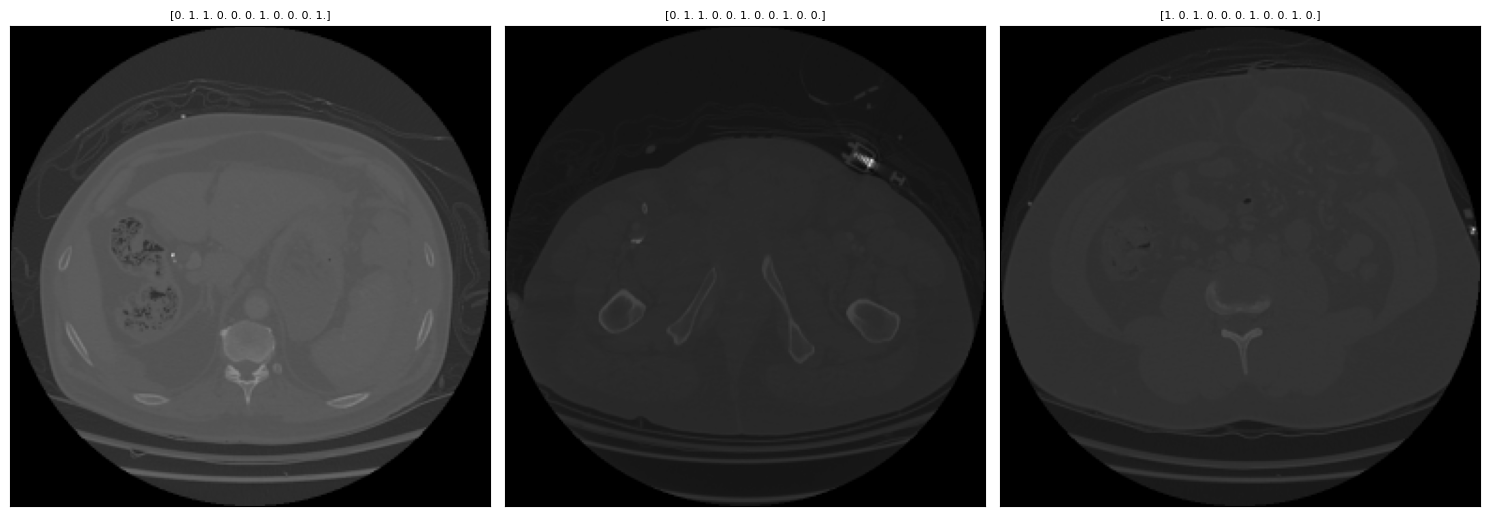

In [10]:
display_batch(batch, 3)

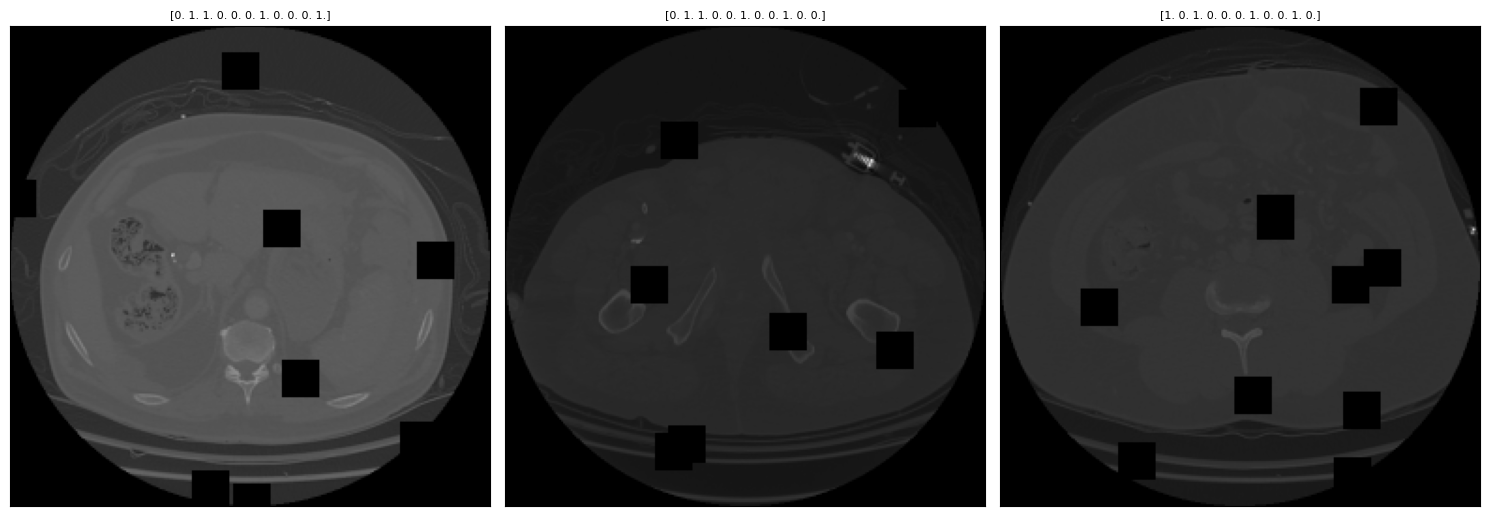

In [11]:
dropout_imgs = tf.map_fn(lambda img: dropout(img,
                DIM=CFG.img_size, 
                PROBABILITY=1.0, 
                cutout=10,
                size=0.08), batch[0])
dropout_targets = batch[1]
display_batch((dropout_imgs, dropout_targets), 3)

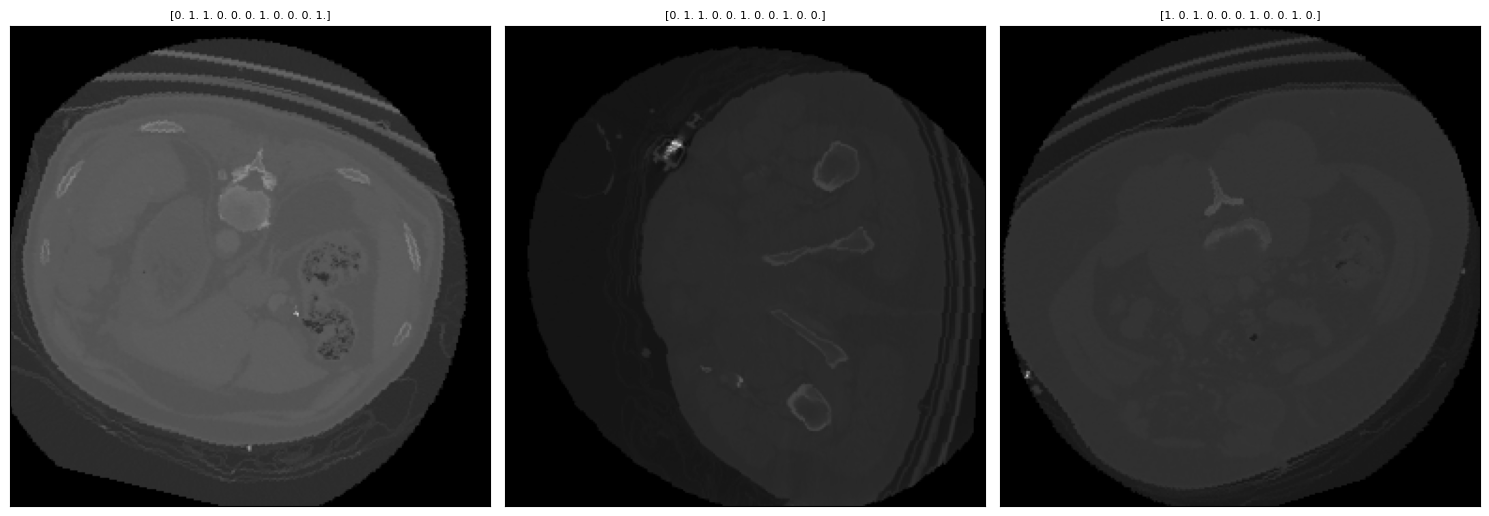

In [12]:
transform_imgs = tf.map_fn(lambda img: transform(img,DIM=CFG.img_size), batch[0])
transform_targets = batch[1]
display_batch((transform_imgs, transform_targets), 3)

### Build model

In [13]:
from keras_cv_attention_models import efficientnet

'''
def channel_squeezer(x):

    # Expand 4 channels to 32 features
    x = tf.keras.layers.Conv2D(32, (3, 3), padding='same', activation='gelu')(x)
    # Squeeze 32 features into 3 channels
    x = tf.keras.layers.Conv2D(3, (3, 3), padding='same', activation='gelu')(x)

    return x
'''


def build_model(model_name=CFG.model_name,
                loss_name=CFG.loss,
                dim=CFG.img_size,
                compile_model=True,
                include_top=False):
    
    '''
    # Input layer for 4-channel images
    input = tf.keras.layers.Input(shape=(*dim, 4))
    # Squeeze 4 channels to 3 channels
    x = channel_squeezer(input)
    '''

    # Define backbone
    base = getattr(efficientnet, model_name)(input_shape=(*dim,3), pretrained='imagenet', num_classes=0)
    input = base.inputs
    x = base.output
    # https://qiita.com/mine820/items/1e49bca6d215ce88594a
    x = tf.keras.layers.GlobalAveragePooling2D()(x)

    # Data go through necks
    x_bowel = tf.keras.layers.Dense(32, activation='silu')(x)
    x_extra = tf.keras.layers.Dense(32, activation='silu')(x)
    x_liver = tf.keras.layers.Dense(32, activation='silu')(x)
    x_kidney = tf.keras.layers.Dense(32, activation='silu')(x)
    x_spleen = tf.keras.layers.Dense(32, activation='silu')(x)

    # Data go through heads
    # Use sigmoid for binary class
    # Use softmax for multi class
    out_bowel = tf.keras.layers.Dense(1, name='bowel', activation='sigmoid')(x_bowel)
    out_extra = tf.keras.layers.Dense(1, name='extra', activation='sigmoid')(x_extra)
    out_liver = tf.keras.layers.Dense(3, name='liver', activation='softmax')(x_liver)
    out_kidney = tf.keras.layers.Dense(3, name='kidney', activation='softmax')(x_kidney)
    out_spleen = tf.keras.layers.Dense(3, name='spleen', activation='softmax')(x_spleen)

    # Output
    output = [out_bowel, out_extra, out_liver, out_kidney, out_spleen]

    # Create model
    model = tf.keras.Model(inputs=input, outputs=output)

    if compile_model:

        optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=0.0001)

        # 'tfa.losses.SigmoidFocalCrossEntropy' also can be used for bowel and extra
        # https://developers.microad.co.jp/entry/2021/04/26/060000
        loss = {'bowel':tf.keras.losses.BinaryCrossentropy(label_smoothing=0.05),
                'extra':tf.keras.losses.BinaryCrossentropy(label_smoothing=0.05),
                'liver':tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.05),
                'kidney':tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.05),
                'spleen':tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.05)}

        metrics = {'bowel':'accuracy',
                   'extra':'accuracy',
                   'liver':'accuracy',
                   'kidney':'accuracy',
                   'spleen':'accuracy'}
        
        model.compile(optimizer=optimizer,
                      loss=loss,
                      metrics=metrics)
        
    return model

In [14]:
tmp = build_model(CFG.model_name, dim=CFG.img_size, compile_model=True)
tmp.summary() 

>>>> Load pretrained from: /Users/makoto/.keras/models/efficientnetv2-b1-imagenet.h5
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 stem_conv (Conv2D)          (None, 128, 128, 32)         864       ['input_1[0][0]']             
                                                                                                  
 stem_bn (BatchNormalizatio  (None, 128, 128, 32)         128       ['stem_conv[0][0]']           
 n)                                                                                               
                                                                                                  
 stem_swi

In [15]:
wandb.login()
os.environ["WANDB_NOTEBOOK_NAME"] = "RSNA2023ATDEfficientnet"


def wandb_init(fold):

    config = {key:value for key,value in dict(vars(CFG)).items()}
    config.update({"fold":int(fold)})

    run = wandb.init(project="RSNA2023ATDEfficientnet", 
                     name=f"fold-{fold}|dim-{CFG.img_size[0]}x{CFG.img_size[1]}|model-{CFG.model_name}",
                     config=config,
                     group=CFG.comment)
    
    return run


def log_wandb(fold):

    wandb.log({'best_acc': best_acc,
               'best_loss': best_loss,
               'best_epoch': best_epoch+1,
               'best_acc_bowel': best_acc_bowel,
               'best_acc_extra': best_acc_extra,
               'best_acc_liver': best_acc_liver,
               'best_acc_kidney': best_acc_kidney,
               'best_acc_spleen': best_acc_spleen})

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: m-noda. Use `wandb login --relogin` to force relogin


In [16]:
def get_wb_callbacks(fold):
    wb_ckpt = wandb.keras.WandbModelCheckpoint(filepath='fold-%i.h5'%fold, 
                                               monitor='val_loss',
                                               verbose=CFG.verbose,
                                               save_best_only=True,
                                               save_weights_only=False,
                                               mode='min',)
    wb_metr = wandb.keras.WandbMetricsLogger()
    return [wb_ckpt, wb_metr]

In [17]:
scores = []

for fold in np.arange(CFG.folds):
    
    # ignore not selected folds
    if fold not in CFG.selected_folds:
        continue

    # init wandb
    if CFG.wandb:
        run = wandb_init(fold)
        wb_callbacks = get_wb_callbacks(fold)

    train_df = df.query("fold!=@fold")
    valid_df = df.query("fold==@fold")

    # get image_paths and labels
    train_paths  = train_df.image_path.values
    train_labels = train_df[CFG.target_col].values.astype(np.float32)
    valid_paths  = valid_df.image_path.values
    valid_labels = valid_df[CFG.target_col].values.astype(np.float32)
    test_paths   = test_df.image_path.values

    index = np.arange(len(train_df))
    np.random.shuffle(index)
    train_paths  = train_paths[index]
    train_labels = train_labels[index]

     # min samples in debug mode
    min_samples = CFG.batch_size*CFG.REPLICAS*2
    
    # for debug model run on small portion
    if CFG.debug:
        train_paths  = train_paths[:min_samples]
        train_labels = train_labels[:min_samples]
        valid_paths  = valid_paths[:min_samples]
        valid_labels = valid_labels[:min_samples]

    # data stat
    num_train = len(train_paths)
    num_valid = len(valid_paths)

    if CFG.wandb:
        wandb.log({'num_train':num_train,
                   'num_valid':num_valid})
        
    print('NUM_TRAIN: {:,} | NUM_VALID: {:,}'.format(num_train, num_valid))

    K.clear_session()
    strategy = tf.distribute.MirroredStrategy()

    # build model
    with strategy.scope():
        model = build_model(CFG.model_name, dim=CFG.img_size, compile_model=True)

    train_ds = build_dataset(train_paths, train_labels, cache=0, 
                             batch_size=CFG.batch_size*CFG.REPLICAS,
                             repeat=True, shuffle=True, augment=False)
    valid_ds = build_dataset(valid_paths, valid_labels, cache=0, 
                           batch_size=CFG.batch_size*CFG.REPLICAS,
                           repeat=False, shuffle=False, augment=CFG.augment)
    
    callbacks = []

    save = tf.keras.callbacks.ModelCheckpoint('fold-%i.h5'%fold, monitor='val_loss', 
                                              verbose=CFG.verbose, save_best_only=True,
                                              save_weights_only=False, mode='min', save_freq='epoch')
    
    callbacks += [save]

    if CFG.wandb:
        callbacks += wb_callbacks
  
    #train
    print('Training...')
    history = model.fit(train_ds, 
                        epochs=CFG.epochs if not CFG.debug else 2, 
                        callbacks = callbacks, 
                        steps_per_epoch=len(train_paths)/CFG.batch_size//CFG.REPLICAS,
                        validation_data=valid_ds, 
                        verbose=CFG.verbose)

    
    # store best results
    best_epoch = np.argmin(history.history['val_loss'])
    best_loss = history.history['val_loss'][best_epoch]
    best_acc_bowel = history.history['val_bowel_accuracy'][best_epoch]
    best_acc_extra = history.history['val_extra_accuracy'][best_epoch]
    best_acc_liver = history.history['val_liver_accuracy'][best_epoch]
    best_acc_kidney = history.history['val_kidney_accuracy'][best_epoch]
    best_acc_spleen = history.history['val_spleen_accuracy'][best_epoch]
    

    # Find mean accuracy
    best_acc = np.mean([best_acc_bowel, best_acc_extra, best_acc_liver, best_acc_kidney, best_acc_spleen])

    print(f'FOLD {fold} RESULTS')
    print(f'BEST Loss  : {best_loss:.3f}\nBEST Acc   : {best_acc:.3f}\nBEST Epoch : {best_epoch}\n')
    print(f'Bowel : {best_acc_bowel:.3f}')
    print(f'Extravasation : {best_acc_extra:.3f}')
    print(f'Liver: {best_acc_liver:.3f}')
    print(f'Kidney: {best_acc_kidney:.3f}')
    print(f'Spleen: {best_acc_spleen:.3f}')

    scores.append([best_loss, best_acc, 
                   best_acc_bowel, best_acc_extra, 
                   best_acc_liver, best_acc_kidney, best_acc_spleen])
    
    if CFG.wandb:
        log_wandb(fold) # log
        wandb.run.finish() # finish the run
        display(ipd.IFrame(run.url, width=1080, height=720)) # show wandb dashboard


NUM_TRAIN: 10,858 | NUM_VALID: 2,157
INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduc

2023-10-05 21:55:56.065215: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:786] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Found an unshardable source dataset: name: "TensorSliceDataset/_2"
op: "TensorSliceDataset"
input: "Placeholder/_0"
input: "Placeholder/_1"
attr {
  key: "Toutput_types"
  value {
    list {
      type: DT_STRING
      type: DT_FLOAT
    }
  }
}
attr {
  key: "_cardinality"
  value {
    i: 10858
  }
}
attr {
  key: "is_files"
  value {
    b: false
  }
}
attr {
  key: "metadata"
  value {
    s: "\n\025TensorSliceDataset:11"
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
      }
      shape {
        dim {
          size: 11
        }
      }
    }
  }
}
attr {
  key: "replicate_on_split"
  value {
    b: false
  }
}
experimental_type {
  type_id: TFT_PRODUCT
  args {
    type_id: TFT_DATASET
    args {
      type_id: TFT_PRODUCT
      args {
   

84/84 [==============================] - ETA: 0s - loss: 1.9042 - bowel_loss: 0.3309 - extra_loss: 0.3301 - liver_loss: 0.3890 - kidney_loss: 0.4275 - spleen_loss: 0.4268 - bowel_accuracy: 0.9019 - extra_accuracy: 0.9014 - liver_accuracy: 0.9298 - kidney_accuracy: 0.9058 - spleen_accuracy: 0.9099

2023-10-05 22:01:17.888955: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:786] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Found an unshardable source dataset: name: "TensorSliceDataset/_2"
op: "TensorSliceDataset"
input: "Placeholder/_0"
input: "Placeholder/_1"
attr {
  key: "Toutput_types"
  value {
    list {
      type: DT_STRING
      type: DT_FLOAT
    }
  }
}
attr {
  key: "_cardinality"
  value {
    i: 2157
  }
}
attr {
  key: "is_files"
  value {
    b: false
  }
}
attr {
  key: "metadata"
  value {
    s: "\n\025TensorSliceDataset:18"
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
      }
      shape {
        dim {
          size: 11
        }
      }
    }
  }
}
attr {
  key: "replicate_on_split"
  value {
    b: false
  }
}
experimental_type {
  type_id: TFT_PRODUCT
  args {
    type_id: TFT_DATASET
    args {
      type_id: TFT_PRODUCT
      args {
    


Epoch 1: val_loss improved from inf to 3.49995, saving model to fold-0.h5


/Users/makoto/homebrew/Caskroom/miniforge/base/envs/rsna2023/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


84/84 [==============================] - 368s 4s/step - loss: 1.9042 - bowel_loss: 0.3309 - extra_loss: 0.3301 - liver_loss: 0.3890 - kidney_loss: 0.4275 - spleen_loss: 0.4268 - bowel_accuracy: 0.9019 - extra_accuracy: 0.9014 - liver_accuracy: 0.9298 - kidney_accuracy: 0.9058 - spleen_accuracy: 0.9099 - val_loss: 3.4999 - val_bowel_loss: 0.6941 - val_extra_loss: 0.5909 - val_liver_loss: 0.3798 - val_kidney_loss: 0.7707 - val_spleen_loss: 1.0645 - val_bowel_accuracy: 0.6263 - val_extra_accuracy: 0.7126 - val_liver_accuracy: 0.9638 - val_kidney_accuracy: 0.7473 - val_spleen_accuracy: 0.6045
Epoch 2/5
84/84 [==============================] - ETA: 0s - loss: 0.8229 - bowel_loss: 0.1276 - extra_loss: 0.1261 - liver_loss: 0.1899 - kidney_loss: 0.1898 - spleen_loss: 0.1895 - bowel_accuracy: 0.9990 - extra_accuracy: 0.9992 - liver_accuracy: 0.9977 - kidney_accuracy: 0.9958 - spleen_accuracy: 0.9969

2023-10-05 22:06:33.042456: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-10-05 22:06:33.046031: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-10-05 22:06:33.141600: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-10-05 22:06:33.144776: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.



Epoch 2: val_loss did not improve from 3.49995
84/84 [==============================] - 282s 3s/step - loss: 0.8229 - bowel_loss: 0.1276 - extra_loss: 0.1261 - liver_loss: 0.1899 - kidney_loss: 0.1898 - spleen_loss: 0.1895 - bowel_accuracy: 0.9990 - extra_accuracy: 0.9992 - liver_accuracy: 0.9977 - kidney_accuracy: 0.9958 - spleen_accuracy: 0.9969 - val_loss: 3.5679 - val_bowel_loss: 0.6858 - val_extra_loss: 0.6102 - val_liver_loss: 0.4187 - val_kidney_loss: 0.8009 - val_spleen_loss: 1.0523 - val_bowel_accuracy: 0.6430 - val_extra_accuracy: 0.7116 - val_liver_accuracy: 0.9434 - val_kidney_accuracy: 0.7441 - val_spleen_accuracy: 0.5953
Epoch 3/5
84/84 [==============================] - ETA: 0s - loss: 0.7623 - bowel_loss: 0.1201 - extra_loss: 0.1198 - liver_loss: 0.1739 - kidney_loss: 0.1743 - spleen_loss: 0.1742 - bowel_accuracy: 1.0000 - extra_accuracy: 1.0000 - liver_accuracy: 1.0000 - kidney_accuracy: 0.9998 - spleen_accuracy: 0.9999

2023-10-05 22:11:16.684891: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-10-05 22:11:16.688442: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-10-05 22:11:16.786575: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-10-05 22:11:16.789862: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.



Epoch 3: val_loss did not improve from 3.49995
84/84 [==============================] - 284s 3s/step - loss: 0.7623 - bowel_loss: 0.1201 - extra_loss: 0.1198 - liver_loss: 0.1739 - kidney_loss: 0.1743 - spleen_loss: 0.1742 - bowel_accuracy: 1.0000 - extra_accuracy: 1.0000 - liver_accuracy: 1.0000 - kidney_accuracy: 0.9998 - spleen_accuracy: 0.9999 - val_loss: 3.6016 - val_bowel_loss: 0.6851 - val_extra_loss: 0.6149 - val_liver_loss: 0.4277 - val_kidney_loss: 0.8068 - val_spleen_loss: 1.0671 - val_bowel_accuracy: 0.6398 - val_extra_accuracy: 0.7135 - val_liver_accuracy: 0.9356 - val_kidney_accuracy: 0.7330 - val_spleen_accuracy: 0.5925
Epoch 4/5
84/84 [==============================] - ETA: 0s - loss: 0.7536 - bowel_loss: 0.1193 - extra_loss: 0.1189 - liver_loss: 0.1717 - kidney_loss: 0.1716 - spleen_loss: 0.1722 - bowel_accuracy: 1.0000 - extra_accuracy: 1.0000 - liver_accuracy: 1.0000 - kidney_accuracy: 0.9999 - spleen_accuracy: 1.0000

2023-10-05 22:15:55.528410: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-10-05 22:15:55.532015: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-10-05 22:15:55.630255: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-10-05 22:15:55.633533: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.



Epoch 4: val_loss did not improve from 3.49995
84/84 [==============================] - 279s 3s/step - loss: 0.7536 - bowel_loss: 0.1193 - extra_loss: 0.1189 - liver_loss: 0.1717 - kidney_loss: 0.1716 - spleen_loss: 0.1722 - bowel_accuracy: 1.0000 - extra_accuracy: 1.0000 - liver_accuracy: 1.0000 - kidney_accuracy: 0.9999 - spleen_accuracy: 1.0000 - val_loss: 3.5857 - val_bowel_loss: 0.6805 - val_extra_loss: 0.6224 - val_liver_loss: 0.4236 - val_kidney_loss: 0.8040 - val_spleen_loss: 1.0552 - val_bowel_accuracy: 0.6518 - val_extra_accuracy: 0.7061 - val_liver_accuracy: 0.9360 - val_kidney_accuracy: 0.7316 - val_spleen_accuracy: 0.6032
Epoch 5/5
84/84 [==============================] - ETA: 0s - loss: 0.7509 - bowel_loss: 0.1187 - extra_loss: 0.1186 - liver_loss: 0.1710 - kidney_loss: 0.1710 - spleen_loss: 0.1715 - bowel_accuracy: 1.0000 - extra_accuracy: 1.0000 - liver_accuracy: 1.0000 - kidney_accuracy: 1.0000 - spleen_accuracy: 1.0000

2023-10-05 22:20:34.237508: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-10-05 22:20:34.241008: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-10-05 22:20:34.338492: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-10-05 22:20:34.341912: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.



Epoch 5: val_loss did not improve from 3.49995
84/84 [==============================] - 279s 3s/step - loss: 0.7509 - bowel_loss: 0.1187 - extra_loss: 0.1186 - liver_loss: 0.1710 - kidney_loss: 0.1710 - spleen_loss: 0.1715 - bowel_accuracy: 1.0000 - extra_accuracy: 1.0000 - liver_accuracy: 1.0000 - kidney_accuracy: 1.0000 - spleen_accuracy: 1.0000 - val_loss: 3.5499 - val_bowel_loss: 0.6700 - val_extra_loss: 0.6120 - val_liver_loss: 0.4192 - val_kidney_loss: 0.7935 - val_spleen_loss: 1.0552 - val_bowel_accuracy: 0.6555 - val_extra_accuracy: 0.7153 - val_liver_accuracy: 0.9393 - val_kidney_accuracy: 0.7455 - val_spleen_accuracy: 0.5920
FOLD 0 RESULTS
BEST Loss  : 3.500
BEST Acc   : 0.731
BEST Epoch : 0

Bowel : 0.626
Extravasation : 0.713
Liver: 0.964
Kidney: 0.747
Spleen: 0.605
NUM_TRAIN: 10,511 | NUM_VALID: 2,504
INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)
>>>> Load pretrained from: /Users/makoto/.keras/models/efficientnetv2-b

2023-10-05 22:20:56.090178: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:786] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Found an unshardable source dataset: name: "TensorSliceDataset/_2"
op: "TensorSliceDataset"
input: "Placeholder/_0"
input: "Placeholder/_1"
attr {
  key: "Toutput_types"
  value {
    list {
      type: DT_STRING
      type: DT_FLOAT
    }
  }
}
attr {
  key: "_cardinality"
  value {
    i: 10511
  }
}
attr {
  key: "is_files"
  value {
    b: false
  }
}
attr {
  key: "metadata"
  value {
    s: "\n\025TensorSliceDataset:82"
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
      }
      shape {
        dim {
          size: 11
        }
      }
    }
  }
}
attr {
  key: "replicate_on_split"
  value {
    b: false
  }
}
experimental_type {
  type_id: TFT_PRODUCT
  args {
    type_id: TFT_DATASET
    args {
      type_id: TFT_PRODUCT
      args {
   

82/82 [==============================] - ETA: 0s - loss: 1.9129 - bowel_loss: 0.3432 - extra_loss: 0.3125 - liver_loss: 0.4299 - kidney_loss: 0.3859 - spleen_loss: 0.4414 - bowel_accuracy: 0.9122 - extra_accuracy: 0.9061 - liver_accuracy: 0.9220 - kidney_accuracy: 0.9304 - spleen_accuracy: 0.9028

2023-10-05 22:26:22.189296: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:786] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Found an unshardable source dataset: name: "TensorSliceDataset/_2"
op: "TensorSliceDataset"
input: "Placeholder/_0"
input: "Placeholder/_1"
attr {
  key: "Toutput_types"
  value {
    list {
      type: DT_STRING
      type: DT_FLOAT
    }
  }
}
attr {
  key: "_cardinality"
  value {
    i: 2504
  }
}
attr {
  key: "is_files"
  value {
    b: false
  }
}
attr {
  key: "metadata"
  value {
    s: "\n\025TensorSliceDataset:89"
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
      }
      shape {
        dim {
          size: 11
        }
      }
    }
  }
}
attr {
  key: "replicate_on_split"
  value {
    b: false
  }
}
experimental_type {
  type_id: TFT_PRODUCT
  args {
    type_id: TFT_DATASET
    args {
      type_id: TFT_PRODUCT
      args {
    


Epoch 1: val_loss improved from inf to 3.19265, saving model to fold-1.h5


/Users/makoto/homebrew/Caskroom/miniforge/base/envs/rsna2023/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


82/82 [==============================] - 373s 4s/step - loss: 1.9129 - bowel_loss: 0.3432 - extra_loss: 0.3125 - liver_loss: 0.4299 - kidney_loss: 0.3859 - spleen_loss: 0.4414 - bowel_accuracy: 0.9122 - extra_accuracy: 0.9061 - liver_accuracy: 0.9220 - kidney_accuracy: 0.9304 - spleen_accuracy: 0.9028 - val_loss: 3.1927 - val_bowel_loss: 0.7559 - val_extra_loss: 0.7924 - val_liver_loss: 0.4411 - val_kidney_loss: 0.7074 - val_spleen_loss: 0.4959 - val_bowel_accuracy: 0.5451 - val_extra_accuracy: 0.6122 - val_liver_accuracy: 0.9233 - val_kidney_accuracy: 0.8247 - val_spleen_accuracy: 0.8914
Epoch 2/5
82/82 [==============================] - ETA: 0s - loss: 0.8180 - bowel_loss: 0.1260 - extra_loss: 0.1247 - liver_loss: 0.1882 - kidney_loss: 0.1898 - spleen_loss: 0.1893 - bowel_accuracy: 0.9991 - extra_accuracy: 0.9998 - liver_accuracy: 0.9961 - kidney_accuracy: 0.9944 - spleen_accuracy: 0.9971

2023-10-05 22:31:29.706713: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-10-05 22:31:29.710207: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-10-05 22:31:29.805789: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-10-05 22:31:29.809008: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.



Epoch 2: val_loss did not improve from 3.19265
82/82 [==============================] - 276s 3s/step - loss: 0.8180 - bowel_loss: 0.1260 - extra_loss: 0.1247 - liver_loss: 0.1882 - kidney_loss: 0.1898 - spleen_loss: 0.1893 - bowel_accuracy: 0.9991 - extra_accuracy: 0.9998 - liver_accuracy: 0.9961 - kidney_accuracy: 0.9944 - spleen_accuracy: 0.9971 - val_loss: 3.3596 - val_bowel_loss: 0.7883 - val_extra_loss: 0.8450 - val_liver_loss: 0.4453 - val_kidney_loss: 0.7105 - val_spleen_loss: 0.5705 - val_bowel_accuracy: 0.5399 - val_extra_accuracy: 0.5887 - val_liver_accuracy: 0.9093 - val_kidney_accuracy: 0.8179 - val_spleen_accuracy: 0.8295
Epoch 3/5
82/82 [==============================] - ETA: 0s - loss: 0.7630 - bowel_loss: 0.1201 - extra_loss: 0.1196 - liver_loss: 0.1740 - kidney_loss: 0.1746 - spleen_loss: 0.1748 - bowel_accuracy: 1.0000 - extra_accuracy: 1.0000 - liver_accuracy: 0.9997 - kidney_accuracy: 0.9996 - spleen_accuracy: 0.9998

2023-10-05 22:36:07.150794: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-10-05 22:36:07.154301: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-10-05 22:36:07.253024: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-10-05 22:36:07.255974: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.



Epoch 3: val_loss did not improve from 3.19265
82/82 [==============================] - 277s 3s/step - loss: 0.7630 - bowel_loss: 0.1201 - extra_loss: 0.1196 - liver_loss: 0.1740 - kidney_loss: 0.1746 - spleen_loss: 0.1748 - bowel_accuracy: 1.0000 - extra_accuracy: 1.0000 - liver_accuracy: 0.9997 - kidney_accuracy: 0.9996 - spleen_accuracy: 0.9998 - val_loss: 3.3374 - val_bowel_loss: 0.7811 - val_extra_loss: 0.8412 - val_liver_loss: 0.4388 - val_kidney_loss: 0.7039 - val_spleen_loss: 0.5724 - val_bowel_accuracy: 0.5395 - val_extra_accuracy: 0.5915 - val_liver_accuracy: 0.9117 - val_kidney_accuracy: 0.8195 - val_spleen_accuracy: 0.8383
Epoch 4/5
82/82 [==============================] - ETA: 0s - loss: 0.7538 - bowel_loss: 0.1190 - extra_loss: 0.1187 - liver_loss: 0.1716 - kidney_loss: 0.1719 - spleen_loss: 0.1726 - bowel_accuracy: 1.0000 - extra_accuracy: 1.0000 - liver_accuracy: 0.9998 - kidney_accuracy: 1.0000 - spleen_accuracy: 0.9999

2023-10-05 22:40:42.348704: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-10-05 22:40:42.352318: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-10-05 22:40:42.449104: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-10-05 22:40:42.452198: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.



Epoch 4: val_loss did not improve from 3.19265
82/82 [==============================] - 275s 3s/step - loss: 0.7538 - bowel_loss: 0.1190 - extra_loss: 0.1187 - liver_loss: 0.1716 - kidney_loss: 0.1719 - spleen_loss: 0.1726 - bowel_accuracy: 1.0000 - extra_accuracy: 1.0000 - liver_accuracy: 0.9998 - kidney_accuracy: 1.0000 - spleen_accuracy: 0.9999 - val_loss: 3.3385 - val_bowel_loss: 0.7776 - val_extra_loss: 0.8350 - val_liver_loss: 0.4441 - val_kidney_loss: 0.7013 - val_spleen_loss: 0.5806 - val_bowel_accuracy: 0.5427 - val_extra_accuracy: 0.5966 - val_liver_accuracy: 0.9073 - val_kidney_accuracy: 0.8175 - val_spleen_accuracy: 0.8371
Epoch 5/5
82/82 [==============================] - ETA: 0s - loss: 0.7509 - bowel_loss: 0.1186 - extra_loss: 0.1183 - liver_loss: 0.1709 - kidney_loss: 0.1711 - spleen_loss: 0.1720 - bowel_accuracy: 1.0000 - extra_accuracy: 1.0000 - liver_accuracy: 1.0000 - kidney_accuracy: 1.0000 - spleen_accuracy: 1.0000

2023-10-05 22:45:20.036389: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-10-05 22:45:20.039901: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-10-05 22:45:20.138136: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-10-05 22:45:20.141298: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.



Epoch 5: val_loss did not improve from 3.19265
82/82 [==============================] - 277s 3s/step - loss: 0.7509 - bowel_loss: 0.1186 - extra_loss: 0.1183 - liver_loss: 0.1709 - kidney_loss: 0.1711 - spleen_loss: 0.1720 - bowel_accuracy: 1.0000 - extra_accuracy: 1.0000 - liver_accuracy: 1.0000 - kidney_accuracy: 1.0000 - spleen_accuracy: 1.0000 - val_loss: 3.3389 - val_bowel_loss: 0.7727 - val_extra_loss: 0.8360 - val_liver_loss: 0.4451 - val_kidney_loss: 0.6995 - val_spleen_loss: 0.5856 - val_bowel_accuracy: 0.5419 - val_extra_accuracy: 0.5942 - val_liver_accuracy: 0.9077 - val_kidney_accuracy: 0.8219 - val_spleen_accuracy: 0.8343
FOLD 1 RESULTS
BEST Loss  : 3.193
BEST Acc   : 0.759
BEST Epoch : 0

Bowel : 0.545
Extravasation : 0.612
Liver: 0.923
Kidney: 0.825
Spleen: 0.891
NUM_TRAIN: 11,327 | NUM_VALID: 1,688
INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)
>>>> Load pretrained from: /Users/makoto/.keras/models/efficientnetv2-b

2023-10-05 22:45:44.400535: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:786] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Found an unshardable source dataset: name: "TensorSliceDataset/_2"
op: "TensorSliceDataset"
input: "Placeholder/_0"
input: "Placeholder/_1"
attr {
  key: "Toutput_types"
  value {
    list {
      type: DT_STRING
      type: DT_FLOAT
    }
  }
}
attr {
  key: "_cardinality"
  value {
    i: 11327
  }
}
attr {
  key: "is_files"
  value {
    b: false
  }
}
attr {
  key: "metadata"
  value {
    s: "\n\026TensorSliceDataset:153"
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
      }
      shape {
        dim {
          size: 11
        }
      }
    }
  }
}
attr {
  key: "replicate_on_split"
  value {
    b: false
  }
}
experimental_type {
  type_id: TFT_PRODUCT
  args {
    type_id: TFT_DATASET
    args {
      type_id: TFT_PRODUCT
      args {
  

88/88 [==============================] - ETA: 0s - loss: 1.8946 - bowel_loss: 0.3265 - extra_loss: 0.3162 - liver_loss: 0.4327 - kidney_loss: 0.3997 - spleen_loss: 0.4194 - bowel_accuracy: 0.8915 - extra_accuracy: 0.9108 - liver_accuracy: 0.9192 - kidney_accuracy: 0.9263 - spleen_accuracy: 0.9050

2023-10-05 22:51:30.909268: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:786] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Found an unshardable source dataset: name: "TensorSliceDataset/_2"
op: "TensorSliceDataset"
input: "Placeholder/_0"
input: "Placeholder/_1"
attr {
  key: "Toutput_types"
  value {
    list {
      type: DT_STRING
      type: DT_FLOAT
    }
  }
}
attr {
  key: "_cardinality"
  value {
    i: 1688
  }
}
attr {
  key: "is_files"
  value {
    b: false
  }
}
attr {
  key: "metadata"
  value {
    s: "\n\026TensorSliceDataset:160"
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
      }
      shape {
        dim {
          size: 11
        }
      }
    }
  }
}
attr {
  key: "replicate_on_split"
  value {
    b: false
  }
}
experimental_type {
  type_id: TFT_PRODUCT
  args {
    type_id: TFT_DATASET
    args {
      type_id: TFT_PRODUCT
      args {
   


Epoch 1: val_loss improved from inf to 3.62524, saving model to fold-2.h5


/Users/makoto/homebrew/Caskroom/miniforge/base/envs/rsna2023/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


88/88 [==============================] - 393s 4s/step - loss: 1.8946 - bowel_loss: 0.3265 - extra_loss: 0.3162 - liver_loss: 0.4327 - kidney_loss: 0.3997 - spleen_loss: 0.4194 - bowel_accuracy: 0.8915 - extra_accuracy: 0.9108 - liver_accuracy: 0.9192 - kidney_accuracy: 0.9263 - spleen_accuracy: 0.9050 - val_loss: 3.6252 - val_bowel_loss: 0.9927 - val_extra_loss: 0.4625 - val_liver_loss: 0.7803 - val_kidney_loss: 0.5876 - val_spleen_loss: 0.8023 - val_bowel_accuracy: 0.4259 - val_extra_accuracy: 0.7956 - val_liver_accuracy: 0.7695 - val_kidney_accuracy: 0.8720 - val_spleen_accuracy: 0.7305
Epoch 2/5
88/88 [==============================] - ETA: 0s - loss: 0.8158 - bowel_loss: 0.1257 - extra_loss: 0.1246 - liver_loss: 0.1889 - kidney_loss: 0.1914 - spleen_loss: 0.1852 - bowel_accuracy: 0.9993 - extra_accuracy: 0.9996 - liver_accuracy: 0.9933 - kidney_accuracy: 0.9928 - spleen_accuracy: 0.9978

2023-10-05 22:57:04.651929: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-10-05 22:57:04.655420: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-10-05 22:57:04.753121: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-10-05 22:57:04.756217: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.



Epoch 2: val_loss improved from 3.62524 to 3.56382, saving model to fold-2.h5
88/88 [==============================] - 299s 3s/step - loss: 0.8158 - bowel_loss: 0.1257 - extra_loss: 0.1246 - liver_loss: 0.1889 - kidney_loss: 0.1914 - spleen_loss: 0.1852 - bowel_accuracy: 0.9993 - extra_accuracy: 0.9996 - liver_accuracy: 0.9933 - kidney_accuracy: 0.9928 - spleen_accuracy: 0.9978 - val_loss: 3.5638 - val_bowel_loss: 0.9430 - val_extra_loss: 0.4718 - val_liver_loss: 0.7935 - val_kidney_loss: 0.5877 - val_spleen_loss: 0.7679 - val_bowel_accuracy: 0.4935 - val_extra_accuracy: 0.8021 - val_liver_accuracy: 0.7660 - val_kidney_accuracy: 0.8602 - val_spleen_accuracy: 0.7352
Epoch 3/5
88/88 [==============================] - ETA: 0s - loss: 0.7637 - bowel_loss: 0.1198 - extra_loss: 0.1198 - liver_loss: 0.1746 - kidney_loss: 0.1753 - spleen_loss: 0.1742 - bowel_accuracy: 1.0000 - extra_accuracy: 1.0000 - liver_accuracy: 0.9989 - kidney_accuracy: 0.9995 - spleen_accuracy: 0.9998

2023-10-05 23:02:07.160966: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-10-05 23:02:07.164452: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-10-05 23:02:07.261539: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-10-05 23:02:07.264722: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.



Epoch 3: val_loss improved from 3.56382 to 3.55734, saving model to fold-2.h5
88/88 [==============================] - 302s 3s/step - loss: 0.7637 - bowel_loss: 0.1198 - extra_loss: 0.1198 - liver_loss: 0.1746 - kidney_loss: 0.1753 - spleen_loss: 0.1742 - bowel_accuracy: 1.0000 - extra_accuracy: 1.0000 - liver_accuracy: 0.9989 - kidney_accuracy: 0.9995 - spleen_accuracy: 0.9998 - val_loss: 3.5573 - val_bowel_loss: 0.9419 - val_extra_loss: 0.4770 - val_liver_loss: 0.7865 - val_kidney_loss: 0.5947 - val_spleen_loss: 0.7574 - val_bowel_accuracy: 0.4988 - val_extra_accuracy: 0.8086 - val_liver_accuracy: 0.7701 - val_kidney_accuracy: 0.8549 - val_spleen_accuracy: 0.7399
Epoch 4/5
88/88 [==============================] - ETA: 0s - loss: 0.7539 - bowel_loss: 0.1189 - extra_loss: 0.1189 - liver_loss: 0.1716 - kidney_loss: 0.1723 - spleen_loss: 0.1724 - bowel_accuracy: 1.0000 - extra_accuracy: 1.0000 - liver_accuracy: 0.9999 - kidney_accuracy: 0.9998 - spleen_accuracy: 0.9998

2023-10-05 23:07:09.659332: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-10-05 23:07:09.662907: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-10-05 23:07:09.760432: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-10-05 23:07:09.763551: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.



Epoch 4: val_loss improved from 3.55734 to 3.55220, saving model to fold-2.h5
88/88 [==============================] - 303s 3s/step - loss: 0.7539 - bowel_loss: 0.1189 - extra_loss: 0.1189 - liver_loss: 0.1716 - kidney_loss: 0.1723 - spleen_loss: 0.1724 - bowel_accuracy: 1.0000 - extra_accuracy: 1.0000 - liver_accuracy: 0.9999 - kidney_accuracy: 0.9998 - spleen_accuracy: 0.9998 - val_loss: 3.5522 - val_bowel_loss: 0.9298 - val_extra_loss: 0.4823 - val_liver_loss: 0.7839 - val_kidney_loss: 0.5875 - val_spleen_loss: 0.7687 - val_bowel_accuracy: 0.5024 - val_extra_accuracy: 0.8057 - val_liver_accuracy: 0.7666 - val_kidney_accuracy: 0.8602 - val_spleen_accuracy: 0.7316
Epoch 5/5
88/88 [==============================] - ETA: 0s - loss: 0.7504 - bowel_loss: 0.1185 - extra_loss: 0.1185 - liver_loss: 0.1707 - kidney_loss: 0.1712 - spleen_loss: 0.1716 - bowel_accuracy: 1.0000 - extra_accuracy: 1.0000 - liver_accuracy: 1.0000 - kidney_accuracy: 1.0000 - spleen_accuracy: 0.9999

2023-10-05 23:12:36.348205: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-10-05 23:12:36.353959: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-10-05 23:12:36.526044: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-10-05 23:12:36.531327: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.



Epoch 5: val_loss improved from 3.55220 to 3.54177, saving model to fold-2.h5
88/88 [==============================] - 328s 4s/step - loss: 0.7504 - bowel_loss: 0.1185 - extra_loss: 0.1185 - liver_loss: 0.1707 - kidney_loss: 0.1712 - spleen_loss: 0.1716 - bowel_accuracy: 1.0000 - extra_accuracy: 1.0000 - liver_accuracy: 1.0000 - kidney_accuracy: 1.0000 - spleen_accuracy: 0.9999 - val_loss: 3.5418 - val_bowel_loss: 0.9306 - val_extra_loss: 0.4872 - val_liver_loss: 0.7792 - val_kidney_loss: 0.5819 - val_spleen_loss: 0.7628 - val_bowel_accuracy: 0.5089 - val_extra_accuracy: 0.8075 - val_liver_accuracy: 0.7701 - val_kidney_accuracy: 0.8667 - val_spleen_accuracy: 0.7364
FOLD 2 RESULTS
BEST Loss  : 3.542
BEST Acc   : 0.738
BEST Epoch : 4

Bowel : 0.509
Extravasation : 0.807
Liver: 0.770
Kidney: 0.867
Spleen: 0.736


In [18]:
train_ds

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), (TensorSpec(shape=(None, 1), dtype=tf.float32, name=None), TensorSpec(shape=(None, 1), dtype=tf.float32, name=None), TensorSpec(shape=(None, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 3), dtype=tf.float32, name=None)))>

In [19]:
valid_ds

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), (TensorSpec(shape=(None, 1), dtype=tf.float32, name=None), TensorSpec(shape=(None, 1), dtype=tf.float32, name=None), TensorSpec(shape=(None, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 3), dtype=tf.float32, name=None)))>